In [ ]:
# Wstępna obróbka danych
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# 1. WCZYTANIE I PRZYGOTOWANIE DANYCH
df = pd.read_csv("male.csv")

# Czyszczenie i podstawowa obróbka
df['Preferred foot'] = df['Preferred foot'].map({'Left': 0, 'Right': 1})
df['Height'] = df['Height'].astype(str).str.extract(r'(\d+)').astype(float)
df['Weight'] = df['Weight'].astype(str).str.extract(r'(\d+)').astype(float)
df = df.dropna(subset=['Height', 'Weight', 'Position'])

# Parametry do analizy
input_cols = [
    'Acceleration', 'Sprint Speed', 'Agility', 'Balance', 'Jumping', 'Stamina',
    'Strength', 'Preferred foot', 'Height', 'Weight', 'Age'
]

# Lista pozycji do wykresów (sortowanie alfabetyczne)
ALL_POSITIONS = sorted(df['Position'].unique())

# --- A. BOXPLOTY (Rozkład cech względem pozycji) ---
print("Generowanie Boxplotów...")
boxplot_cols = ['Acceleration', 'Sprint Speed', 'Agility', 'Stamina','Balance', 'Jumping', 'Strength', 'Height', 'Weight', 'Age']

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))
axes = axes.flatten()

for i, col in enumerate(boxplot_cols):
    sns.boxplot(
        x='Position',
        y=col,
        data=df,
        palette='viridis',
        order=ALL_POSITIONS,
        ax=axes[i]
    )
    axes[i].set_title(f'Rozkład cechy: {col} dla wszystkich pozycji')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('boxplots_positions.png', dpi=300, bbox_inches='tight')
plt.show()

# --- B. KORELOGRAM (Macierz korelacji) ---
print("Generowanie Korelogramu...")
plt.figure(figsize=(12, 10))
correlation_matrix = df[input_cols].corr()
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=0.5
)
plt.title('Macierz Korelacji Cech Wejściowych')
plt.savefig('korelogram.png', dpi=300, bbox_inches='tight')
plt.show()

# --- C. HISTOGRAMY (Dystrybucja ogólna) ---
print("Generowanie Histogramów...")
histogram_cols = ['Acceleration', 'Sprint Speed', 'Agility', 'Balance', 'Jumping', 'Stamina', 'Strength', 'Height', 'Weight', 'Age']

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 18))
axes = axes.flatten()

for i, col in enumerate(histogram_cols):
    sns.histplot(df[col], bins=20, kde=True, ax=axes[i], color='darkblue')
    axes[i].set_title(f'Histogram rozkładu: {col}')

plt.tight_layout()
plt.savefig('histogramy_ogolne.png', dpi=300, bbox_inches='tight')
plt.show()

# --- WYKRES LICZEBNOŚCI POZYCJI (Przed SMOTE) ---
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Position', palette='viridis', order=df['Position'].value_counts().index)
plt.title('Liczebność zawodników na poszczególnych pozycjach (Zbiór oryginalny)')
plt.xticks(rotation=45)
plt.xlabel('Pozycja')
plt.ylabel('Liczba zawodników')
plt.savefig('liczebnosc_klas.png', dpi=300, bbox_inches='tight')
plt.show()

--- ROZPOCZYNAM GRID SEARCH ---
Fitting 3 folds for each of 96 candidates, totalling 288 fits
--- ZAKOŃCZONO W 405.42 s ---
Najlepsze parametry: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Modele zapisane do plików rf_model.pkl i encoder.pkl

Dokładność modelu: 0.7943858649187803

Raport:
               precision    recall  f1-score   support

         CAM       0.79      0.77      0.78       585
          CB       0.67      0.72      0.69       585
         CDM       0.74      0.79      0.76       585
          CM       0.73      0.62      0.67       585
          GK       0.98      1.00      0.99       585
          LB       0.73      0.89      0.80       585
          LM       0.86      0.77      0.81       585
          LW       0.89      0.91      0.90       585
          RB       0.72      0.82      0.76       585
          RM       0.85      0.76      0.81       584
          RW       0.87      0.90      0.89     

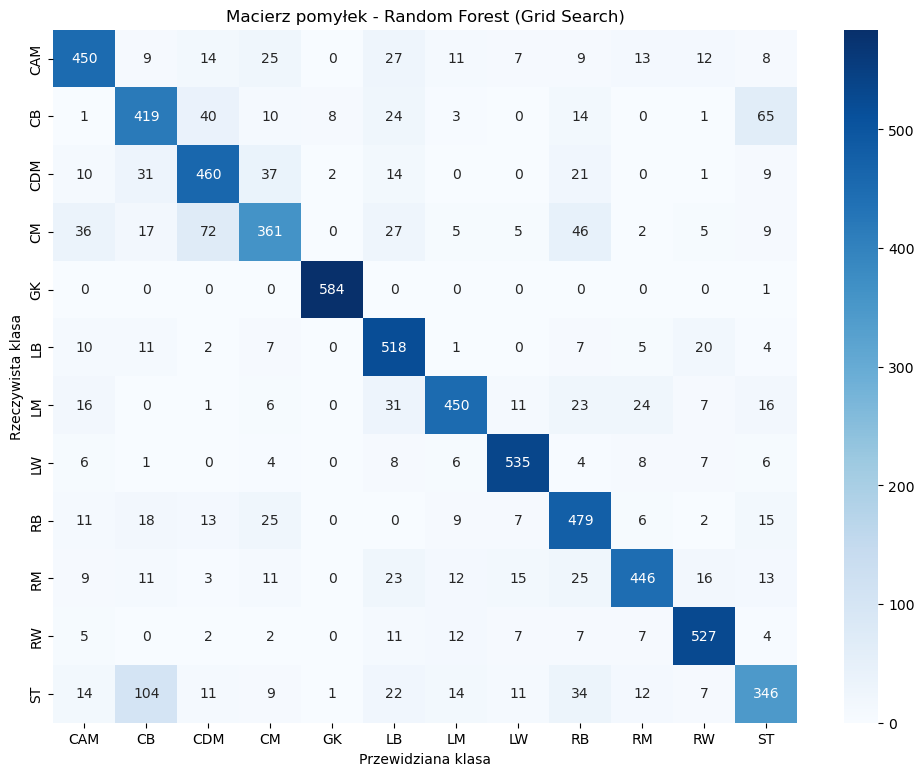

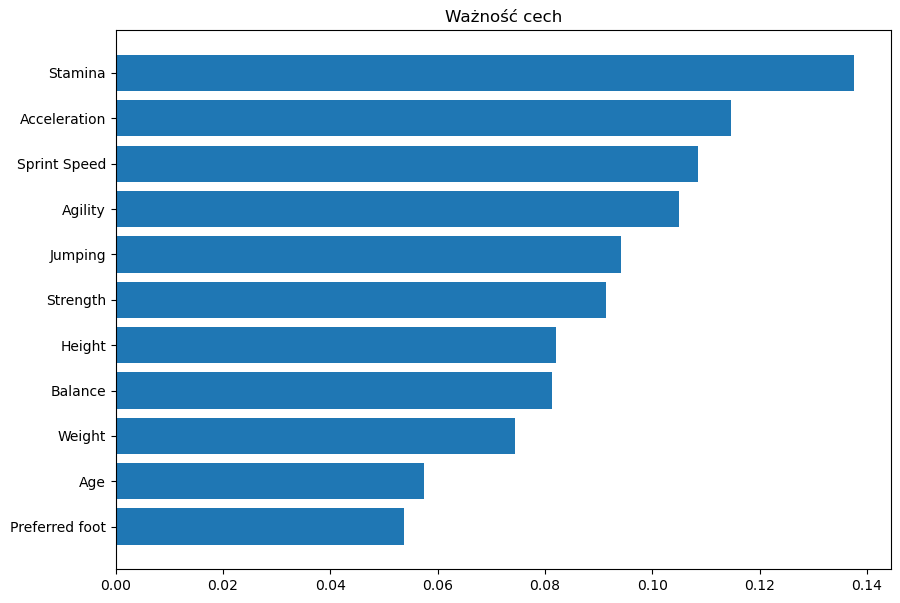

In [4]:
#RandomForest
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# --- 1. WCZYTANIE I OBRÓBKA DANYCH ---
df = pd.read_csv("male.csv")
df['Preferred foot'] = df['Preferred foot'].map({'Left': 0, 'Right': 1})

# Kodowanie pozycji
position_encoder = LabelEncoder()
df['Position_Encoded'] = position_encoder.fit_transform(df['Position'])

# Czyszczenie wzrostu i wagi
df['Height'] = df['Height'].astype(str).str.extract(r'(\d+)').astype(float)
df['Weight'] = df['Weight'].astype(str).str.extract(r'(\d+)').astype(float)
df = df.dropna(subset=['Height', 'Weight', 'Preferred foot'])

# Wejścia i wyjścia
input_cols = [
    'Acceleration', 'Sprint Speed', 'Agility', 'Balance', 'Jumping', 'Stamina',
    'Strength', 'Preferred foot', 'Height', 'Weight', 'Age'
]
X = df[input_cols]
y = df['Position_Encoded']

#  2. SMOTE I PODZIAŁ 
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

# 3. GRID SEARCH 
print("--- ROZPOCZYNAM GRID SEARCH ---")
start_time = time.time()

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy']
}

rf_base = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
end_time = time.time()

# Pobranie najlepszego modelu
model = grid_search.best_estimator_

#  4. ZAPISYWANIE MODELU I ENCODERA 
joblib.dump(model, "rf_model.pkl")
joblib.dump(position_encoder, "encoder.pkl")

print(f"--- ZAKOŃCZONO W {end_time - start_time:.2f} s ---")
print("Najlepsze parametry:", grid_search.best_params_)
print("Modele zapisane do plików rf_model.pkl i encoder.pkl")

# 5. EWALUACJA
y_pred = model.predict(X_test)
print("\nDokładność modelu:", accuracy_score(y_test, y_pred))
print("\nRaport:\n", classification_report(y_test, y_pred, target_names=position_encoder.classes_))

# 6. WIZUALIZACJA 
# Macierz pomyłek
plt.figure(figsize=(12, 9))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=position_encoder.classes_,
            yticklabels=position_encoder.classes_)
plt.title("Macierz pomyłek - Random Forest (Grid Search)")
plt.xlabel("Przewidziana klasa")
plt.ylabel("Rzeczywista klasa")
plt.show()

# Ważność cech
importances = model.feature_importances_
idx = np.argsort(importances)
plt.figure(figsize=(10, 7))
plt.barh(np.array(input_cols)[idx], importances[idx])
plt.title("Ważność cech")
plt.show()



Fitting 3 folds for each of 36 candidates, totalling 108 fits
Najlepsze parametry:
{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.01}

Najlepsza dokładność (CV): 0.5515501491522695
Dokładność modelu: 0.5967512111712738

Raport klasyfikacji:
               precision    recall  f1-score   support

           0       0.56      0.49      0.52       585
           1       0.57      0.68      0.62       585
           2       0.51      0.58      0.55       585
           3       0.41      0.32      0.36       585
           4       0.97      0.99      0.98       585
           5       0.65      0.61      0.63       585
           6       0.45      0.57      0.51       585
           7       0.76      0.72      0.74       585
           8       0.53      0.57      0.55       585
           9       0.50      0.48      0.49       584
          10       0.70      0.75      0.73       584
          11       0.54      0.39      0.45       585

    a

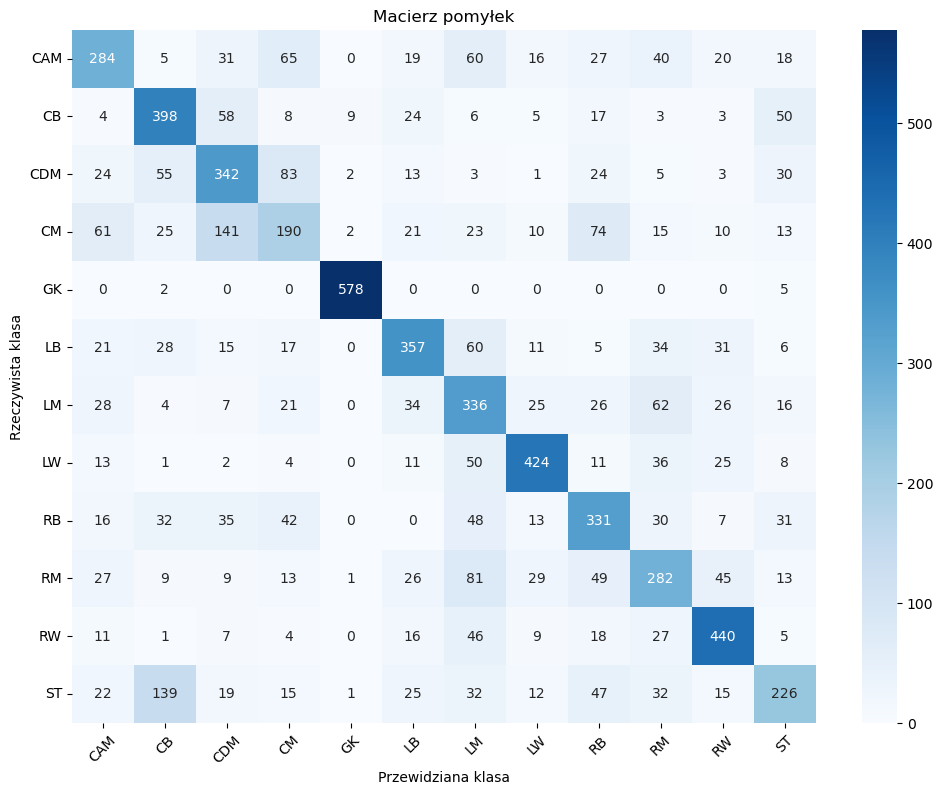

In [2]:
# MLP Classifier (płytka sieć neuronowa - 2 warstwy ukryte)

import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

# WCZYTANIE DANYCH
df = pd.read_csv("male.csv")

# KODOWANIE 
df['Preferred foot'] = df['Preferred foot'].map({'Left': 0, 'Right': 1})

position_encoder = LabelEncoder()
df['Position'] = position_encoder.fit_transform(df['Position'])

df['Height'] = df['Height'].astype(str).str[:3].astype(float)
df['Weight'] = df['Weight'].astype(str).str[:2].astype(float)

#  WEJŚCIA / WYJŚCIA 
input_cols = [
    'Acceleration', 'Sprint Speed', 'Agility', 'Balance', 'Jumping', 'Stamina', 
    'Strength', 'Preferred foot', 'Height', 'Weight', 'Age'
]
output_col = 'Position'

X = df[input_cols]
y = df[output_col]

#  SMOTE 
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

#  PODZIAŁ
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

# SKALOWANIE
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- DEFINICJA MODELU BAZOWEGO ---
mlp = MLPClassifier(
    solver='adam',
    max_iter=1200,
    early_stopping=True,
    n_iter_no_change=20,
    tol=1e-3,
    random_state=42
)

# --- SIATKA HIPERPARAMETRÓW ---
param_grid = {
    'hidden_layer_sizes': [
        (64,), 
        (64, 32),
        (128, 64)
    ],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01]
}

# --- GRID SEARCH ---
grid = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)

print("Najlepsze parametry:")
print(grid.best_params_)

print("\nNajlepsza dokładność (CV):", grid.best_score_)

# --- NAJLEPSZY MODEL ---
best_model = grid.best_estimator_

#  EWALUACJA 
y_pred = best_model.predict(X_test)

print("Dokładność modelu:", accuracy_score(y_test, y_pred))
print("\nRaport klasyfikacji:\n", classification_report(y_test, y_pred, zero_division=0))

#  PRZYKŁADOWA PREDYKCJA 
new_player = pd.DataFrame([{
    'Acceleration': 70, 'Sprint Speed': 65, 'Agility': 75, 'Balance': 75, 
    'Jumping': 60, 'Stamina': 40, 'Strength': 75, 'Preferred foot': 1, 
    'Height': 175, 'Weight': 62, 'Age': 23
}])

new_player_scaled = scaler.transform(new_player)

pred = best_model.predict(new_player_scaled)
print("\nPrzewidywana pozycja:", position_encoder.inverse_transform(pred)[0])

# macierz pomyłek
labels = position_encoder.classes_
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Macierz pomyłek")
plt.xlabel("Przewidziana klasa")
plt.ylabel("Rzeczywista klasa")
plt.xticks(rotation=45) # Obracamy napisy na osi X dla lepszej czytelności
plt.yticks(rotation=0)
plt.show()

Rozpoczynam przeszukiwanie siatki (Grid Search)...
Testowanie: LR=0.001, Dropout=0.1, Batch=32...


D:\Users\Bartek\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Testowanie: LR=0.001, Dropout=0.1, Batch=64...
Testowanie: LR=0.001, Dropout=0.2, Batch=32...
Testowanie: LR=0.001, Dropout=0.2, Batch=64...
Testowanie: LR=0.0005, Dropout=0.1, Batch=32...
Testowanie: LR=0.0005, Dropout=0.1, Batch=64...
Testowanie: LR=0.0005, Dropout=0.2, Batch=32...
Testowanie: LR=0.0005, Dropout=0.2, Batch=64...

Najlepsze parametry: {'lr': 0.001, 'dr': 0.1, 'bs': 32} z dokładnością walidacyjną: 0.5770
Epoch 1/500
702/702 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4015 - loss: 1.6427 - val_accuracy: 0.4311 - val_loss: 1.5230
Epoch 2/500
702/702 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4355 - loss: 1.5290 - val_accuracy: 0.4304 - val_loss: 1.5065
Epoch 3/500
702/702 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4439 - loss: 1.5078 - val_accuracy: 0.4581 - val_loss: 1.4765
Epoch 4/500
702/702 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4507 - loss: 1.4887 - val_accuracy: 0.4555 - val_loss: 1.4862
Epoch 5/500
702/702 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accu

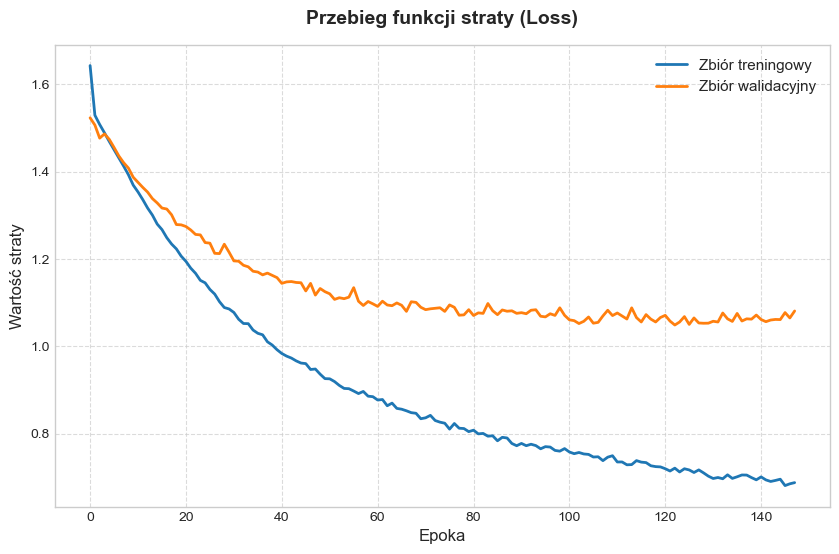

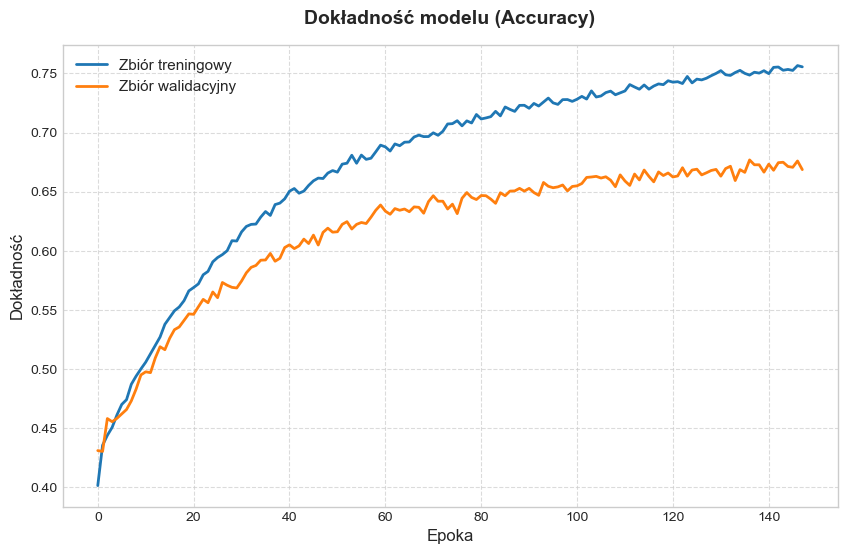

220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


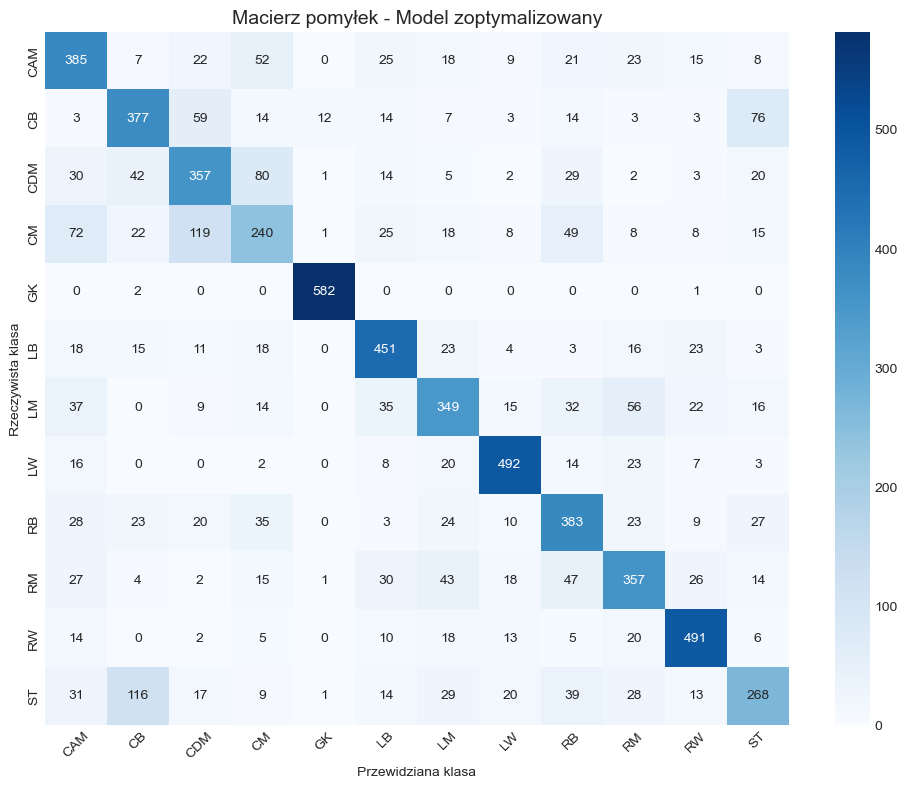


Raport klasyfikacji:
               precision    recall  f1-score   support

         CAM       0.58      0.66      0.62       585
          CB       0.62      0.64      0.63       585
         CDM       0.58      0.61      0.59       585
          CM       0.50      0.41      0.45       585
          GK       0.97      0.99      0.98       585
          LB       0.72      0.77      0.74       585
          LM       0.63      0.60      0.61       585
          LW       0.83      0.84      0.83       585
          RB       0.60      0.65      0.63       585
          RM       0.64      0.61      0.62       584
          RW       0.79      0.84      0.81       584
          ST       0.59      0.46      0.51       585

    accuracy                           0.67      7018
   macro avg       0.67      0.67      0.67      7018
weighted avg       0.67      0.67      0.67      7018



In [7]:
# TensorFlow - głeboka sieć neuronowa (3 warstwy ukryte)
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import SMOTE

# --- 1. WCZYTANIE I PRZYGOTOWANIE DANYCH ---
df = pd.read_csv("male.csv")

df['Preferred foot'] = df['Preferred foot'].map({'Left': 0, 'Right': 1})
position_encoder = LabelEncoder()
df['Position'] = position_encoder.fit_transform(df['Position'])
df['Height'] = df['Height'].astype(str).str[:3].astype(float)
df['Weight'] = df['Weight'].astype(str).str[:2].astype(float)

input_cols = ['Acceleration', 'Sprint Speed', 'Agility', 'Balance', 'Jumping', 'Stamina',
              'Strength', 'Preferred foot', 'Height', 'Weight', 'Age']
output_col = 'Position'

X = df[input_cols]
y = df[output_col]

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- 2. RĘCZNY GRID SEARCH (Bezpieczny dla wersji bibliotek) ---
def build_model(learning_rate, dropout_rate):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(dropout_rate),
        Dense(128, activation='relu'),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dense(len(np.unique(y_res)), activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Definicja siatki parametrów
param_grid = {
    'learning_rate': [0.001, 0.0005],
    'dropout_rate': [0.1, 0.2],
    'batch_size': [32, 64]
}

best_val_acc = 0
best_params = {}

print("Rozpoczynam przeszukiwanie siatki (Grid Search)...")

for lr in param_grid['learning_rate']:
    for dr in param_grid['dropout_rate']:
        for bs in param_grid['batch_size']:
            print(f"Testowanie: LR={lr}, Dropout={dr}, Batch={bs}...")
            
            temp_model = build_model(lr, dr)
            # Trenujemy krótko, aby sprawdzić potencjał parametrów
            h = temp_model.fit(X_train, y_train, validation_split=0.2, 
                               epochs=30, batch_size=bs, verbose=0)
            
            val_acc = max(h.history['val_accuracy'])
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_params = {'lr': lr, 'dr': dr, 'bs': bs}

print(f"\nNajlepsze parametry: {best_params} z dokładnością walidacyjną: {best_val_acc:.4f}")

# --- 3. FINALNY TRENING NA NAJLEPSZYCH PARAMETRACH ---
early_stop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

final_model = build_model(best_params['lr'], best_params['dr'])

history = final_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=500,
    batch_size=best_params['bs'],
    callbacks=[early_stop],
    verbose=1
)

# --- 4. PROFESJONALNE WYKRESY I ZAPIS ---
plt.style.use('seaborn-v0_8-whitegrid')

def plot_and_save(metric, title, ylabel, filename):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history[metric], label='Zbiór treningowy', linewidth=2)
    plt.plot(history.history[f'val_{metric}'], label='Zbiór walidacyjny', linewidth=2)
    plt.title(title, fontsize=14, fontweight='bold', pad=15)
    plt.xlabel('Epoka', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig(f"{filename}.png", dpi=300, bbox_inches='tight')
    plt.savefig(f"{filename}.pdf", bbox_inches='tight')
    plt.show()

plot_and_save('loss', 'Przebieg funkcji straty (Loss)', 'Wartość straty', 'wykres_loss')
plot_and_save('accuracy', 'Dokładność modelu (Accuracy)', 'Dokładność', 'wykres_accuracy')

# --- 5. EWALUACJA I MACIERZ POMYŁEK ---
y_pred = final_model.predict(X_test).argmax(axis=1)
labels = position_encoder.classes_
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Macierz pomyłek - Model zoptymalizowany", fontsize=14)
plt.xlabel("Przewidziana klasa")
plt.ylabel("Rzeczywista klasa")
plt.xticks(rotation=45)
plt.savefig("macierz_pomylek.png", dpi=300, bbox_inches='tight')
plt.show()

print("\nRaport klasyfikacji:\n", classification_report(y_test, y_pred, target_names=labels))


In [14]:
%%writefile app.py
print("Streamlit app!")

Writing app.py


--- Rozpoczynam trening hierarchiczny ---

--- Rozpoczynam GridSearch dla Modelu Grupy (Level 1) ---
Fitting 3 folds for each of 48 candidates, totalling 144 fits
GridSearch Group zakończony w: 48.42 sekund
Najlepsze parametry dla Grupy: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Najlepsza dokładność (CV) dla Grupy: 0.7606
Model Level 1 (Grupa) Accuracy: 0.7700

--- Rozpoczynam GridSearch dla Modelu Defensywy (Level 2A) ---
Fitting 3 folds for each of 48 candidates, totalling 144 fits
GridSearch Defensywa zakończony w: 41.86 sekund
Najlepsze parametry dla Defensywy: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Najlepsza dokładność (CV) dla Defensywy: 0.8706
Model Level 2A (Defensywa) Accuracy: 0.8837

--- Rozpoczynam GridSearch dla Modelu Ofensywy (Level 2B) ---
Fitting 3 folds for each of 48 candidates, totalling 144 fits
GridSearch Ofensywa zakończony w: 53.29 sekund
Najlepsze parametry dla Ofensywy

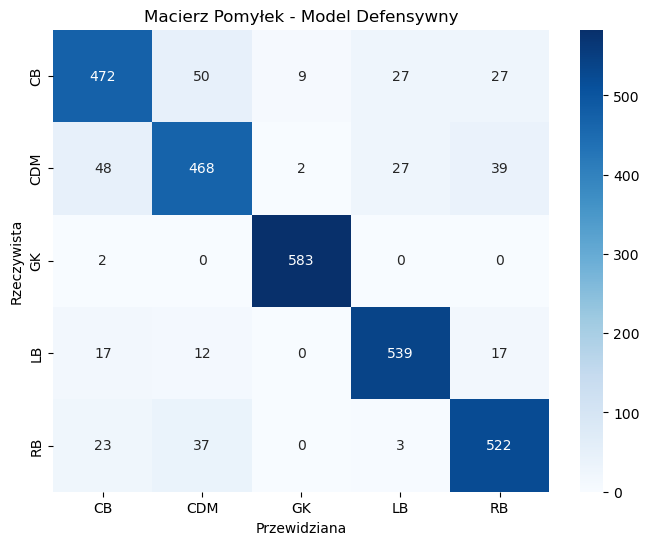

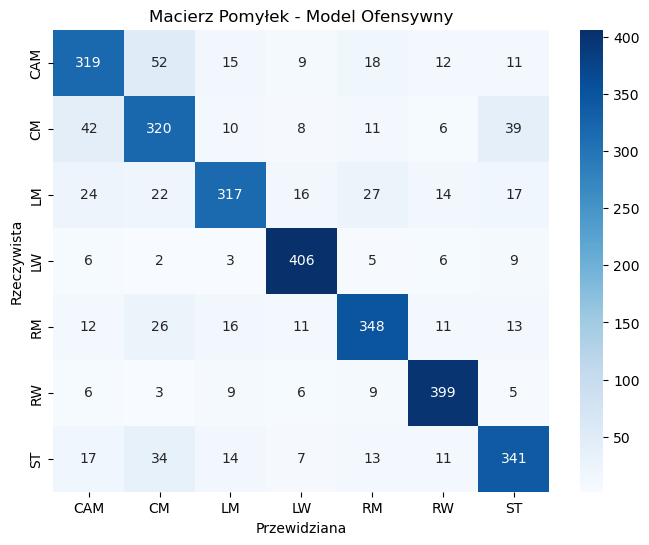

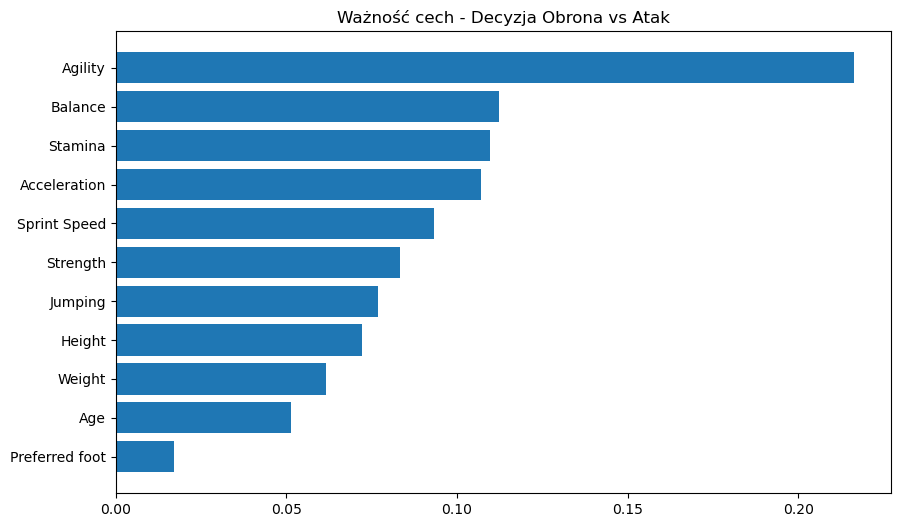

In [1]:
#RF hierarchiczny
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# --- KONFIGURACJA PODZIAŁU POZYCJI ---
DEFENSIVE_POSITIONS = ['GK', 'CB', 'LB', 'RB', 'LWB', 'RWB', 'CDM']
# Reszta (ST, CF, CAM, CM, LM, RM, LW, RW) trafia do OFENSYWY

def get_position_group(pos):
    if pos in DEFENSIVE_POSITIONS:
        return 'Defense'
    return 'Attack'


# 1. PRZYGOTOWANIE DANYCH


df = pd.read_csv("male.csv")

# Kodowanie nogi
df['Preferred foot'] = df['Preferred foot'].map({'Left': 0, 'Right': 1})

# Czyszczenie Wzrostu i Wagi 
df['Height'] = df['Height'].astype(str).str.extract(r'(\d+)').astype(float)
df['Weight'] = df['Weight'].astype(str).str.extract(r'(\d+)').astype(float)
df = df.dropna(subset=['Height', 'Weight'])

# Dodanie kolumny GRUPY (Level 1)
df['Position_Group'] = df['Position'].apply(get_position_group)

# Encodery
# 1. Encoder dla Grupy (Defense vs Attack)
group_encoder = LabelEncoder()
df['Group_Encoded'] = group_encoder.fit_transform(df['Position_Group'])

# 2. Encoder dla Defensywy
df_def = df[df['Position_Group'] == 'Defense'].copy()
encoder_def = LabelEncoder()
df_def['Position_Encoded'] = encoder_def.fit_transform(df_def['Position'])

# 3. Encoder dla Ofensywy
df_att = df[df['Position_Group'] == 'Attack'].copy()
encoder_att = LabelEncoder()
df_att['Position_Encoded'] = encoder_att.fit_transform(df_att['Position'])

# Zdefiniowanie wejść
input_cols = [
    'Acceleration', 'Sprint Speed', 'Agility', 'Balance', 'Jumping', 'Stamina', 
    'Strength', 'Preferred foot', 'Height', 'Weight', 'Age'
]


# 2. TRENING MODELI

print("--- Rozpoczynam trening hierarchiczny ---")

#  MODEL 1: LEVEL 1 (Defense vs Attack)
X = df[input_cols]
y = df['Group_Encoded']

# SMOTE dla Level 1
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

print("\n--- Rozpoczynam GridSearch dla Modelu Grupy (Level 1) ---")

# Definicja siatki hiperparametrów
param_grid_g = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Inicjalizacja klasyfikatora
rf_g = RandomForestClassifier(random_state=42)

# Użycie GridSearchCV

grid_search_g = GridSearchCV(
    estimator=rf_g, 
    param_grid=param_grid_g, 
    cv=3, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=1
)

start_time_g = time.time()
grid_search_g.fit(X_train_g, y_train_g)
end_time_g = time.time()

print(f"GridSearch Group zakończony w: {(end_time_g - start_time_g):.2f} sekund")
print(f"Najlepsze parametry dla Grupy: {grid_search_g.best_params_}")
print(f"Najlepsza dokładność (CV) dla Grupy: {grid_search_g.best_score_:.4f}")

# Przypisanie najlepszego modelu
model_group = grid_search_g.best_estimator_
# Zapisanie najlepszego wyniku CV do zmiennej dla czytelności
best_acc_group_cv = grid_search_g.best_score_

print(f"Model Level 1 (Grupa) Accuracy: {accuracy_score(y_test_g, model_group.predict(X_test_g)):.4f}")

#  MODEL 2A: DEFENSYWA
X_def = df_def[input_cols]
y_def = df_def['Position_Encoded']

# SMOTE dla Defensywy
sm = SMOTE(random_state=42) # Ponowna inicjalizacja SMOTE dla każdego podzbioru
X_res_def, y_res_def = sm.fit_resample(X_def, y_def)
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X_res_def, y_res_def, test_size=0.2, random_state=42, stratify=y_res_def
)

print("\n--- Rozpoczynam GridSearch dla Modelu Defensywy (Level 2A) ---")

# Definicja siatki hiperparametrów
param_grid_d = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Inicjalizacja klasyfikatora
rf_d = RandomForestClassifier(random_state=42)

# Użycie GridSearchCV
grid_search_d = GridSearchCV(
    estimator=rf_d, 
    param_grid=param_grid_d, 
    cv=3, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=1
)

start_time_d = time.time()
grid_search_d.fit(X_train_d, y_train_d)
end_time_d = time.time()

print(f"GridSearch Defensywa zakończony w: {(end_time_d - start_time_d):.2f} sekund")
print(f"Najlepsze parametry dla Defensywy: {grid_search_d.best_params_}")
print(f"Najlepsza dokładność (CV) dla Defensywy: {grid_search_d.best_score_:.4f}")

# Przypisanie najlepszego modelu
model_def = grid_search_d.best_estimator_

print(f"Model Level 2A (Defensywa) Accuracy: {accuracy_score(y_test_d, model_def.predict(X_test_d)):.4f}")

#  MODEL 2B: OFENSYWA
X_att = df_att[input_cols]
y_att = df_att['Position_Encoded']

# SMOTE dla Ofensywy
sm = SMOTE(random_state=42) 
X_res_att, y_res_att = sm.fit_resample(X_att, y_att)
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(
    X_res_att, y_res_att, test_size=0.2, random_state=42, stratify=y_res_att
)

print("\n--- Rozpoczynam GridSearch dla Modelu Ofensywy (Level 2B) ---")

# Definicja siatki hiperparametrów 
param_grid_a = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Inicjalizacja klasyfikatora
rf_a = RandomForestClassifier(random_state=42)

# Użycie GridSearchCV
grid_search_a = GridSearchCV(
    estimator=rf_a, 
    param_grid=param_grid_a, 
    cv=3, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=1
)

start_time_a = time.time()
grid_search_a.fit(X_train_a, y_train_a)
end_time_a = time.time()

print(f"GridSearch Ofensywa zakończony w: {(end_time_a - start_time_a):.2f} sekund")
print(f"Najlepsze parametry dla Ofensywy: {grid_search_a.best_params_}")
print(f"Najlepsza dokładność (CV) dla Ofensywy: {grid_search_a.best_score_:.4f}")

# Przypisanie najlepszego modelu
model_att = grid_search_a.best_estimator_

print(f"Model Level 2B (Ofensywa) Accuracy: {accuracy_score(y_test_a, model_att.predict(X_test_a)):.4f}")

# 3. ZAPIS MODELI I ENCODERÓW

joblib.dump(model_group, "model_level1_group.pkl")
joblib.dump(model_def, "model_level2_def.pkl")
joblib.dump(model_att, "model_level2_att.pkl")

joblib.dump(group_encoder, "encoder_group.pkl")
joblib.dump(encoder_def, "encoder_def.pkl")
joblib.dump(encoder_att, "encoder_att.pkl")

print("\nModele zapisane pomyślnie.")


# 4. SYMULACJA PREDYKCJI 


# Przykładowy gracz
new_player = pd.DataFrame([{
    'Acceleration': 85, 'Sprint Speed': 88, 'Agility': 80, 'Balance': 70, 
    'Jumping': 75, 'Stamina': 80, 'Strength': 60, 'Preferred foot': 1, 
    'Height': 180, 'Weight': 75, 'Age': 23
}])

print("\n--- PREDYKCJA DLA NOWEGO GRACZA ---")

# KROK 1: Przewidywanie Grupy
group_pred_idx = model_group.predict(new_player)[0]
group_name = group_encoder.inverse_transform([group_pred_idx])[0]
group_prob = model_group.predict_proba(new_player)[0][group_pred_idx]

print(f"1. Zidentyfikowana grupa: {group_name.upper()} (Pewność: {group_prob*100:.2f}%)")

# KROK 2: Przewidywanie Szczegółowe w zależności od grupy
if group_name == 'Defense':
    probs = model_def.predict_proba(new_player)[0]
    top3_idx = probs.argsort()[-3:][::-1]
    current_encoder = encoder_def
    print("   Użyto modelu: Defensywnego")
else:
    probs = model_att.predict_proba(new_player)[0]
    top3_idx = probs.argsort()[-3:][::-1]
    current_encoder = encoder_att
    print("   Użyto modelu: Ofensywnego")

print("\nTOP 3 Pozycje wewnątrz grupy:")
for idx in top3_idx:
    pos_name = current_encoder.inverse_transform([idx])[0]
    print(f"   -> {pos_name}: {probs[idx]*100:.2f}%")



# 5. WIZUALIZACJA - MACIERZE POMYŁEK

def plot_cm(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel("Przewidziana")
    plt.ylabel("Rzeczywista")
    plt.show()

# Macierz dla Defensywy
y_pred_d = model_def.predict(X_test_d)
plot_cm(y_test_d, y_pred_d, encoder_def.classes_, "Macierz Pomyłek - Model Defensywny")

# Macierz dla Ofensywy
y_pred_a = model_att.predict(X_test_a)
plot_cm(y_test_a, y_pred_a, encoder_att.classes_, "Macierz Pomyłek - Model Ofensywny")

# Feature Importance (dla modelu Grupy jako przykład)
importances = model_group.feature_importances_
idx = np.argsort(importances)
plt.figure(figsize=(10, 6))
plt.barh(df[input_cols].columns[idx], importances[idx])
plt.title("Ważność cech - Decyzja Obrona vs Atak")
plt.show()